In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2018'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2018'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2018/apr18.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2018/feb18.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2018/jan18.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2018/mar 18.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2018/may18.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 9.45 s, sys: 16.3 ms, total: 9.47 s
Wall time: 14.4 s


In [8]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47015 entries, 0 to 47014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          47015 non-null  object
 1   hour          47015 non-null  int64 
 2   offense_type  47015 non-null  object
 3   beat          47015 non-null  object
 4   premise       47015 non-null  object
 5   block_range   47015 non-null  object
 6   street_name   47014 non-null  object
 7   type          47015 non-null  object
 8   suffix        47015 non-null  object
 9   offenses      47015 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.6+ MB


In [10]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses
0,04/03/2018,14,Theft,10H10,Commercial Building,5900-5999,HARRISBURG,-,-,1
1,04/05/2018,7,Theft,10H10,"Road, Street, or Sidewalk",300-399,DELMAR,ST,-,1
2,04/05/2018,17,Theft,10H10,Apartment,2100-2199,RUNNELS,-,-,1
3,04/05/2018,17,Theft,10H10,Bar or Night Club Parking Lot,2400-2499,NAVIGATION,BLVD,-,1
4,04/07/2018,4,Aggravated Assault,10H10,Residence or House,3300-3399,NAVIGATION,BLVD,-,1


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     1
type            0
suffix          0
offenses        0
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date,0.0
hour,0.0
offense_type,0.0
beat,0.0
premise,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
offenses,0.0


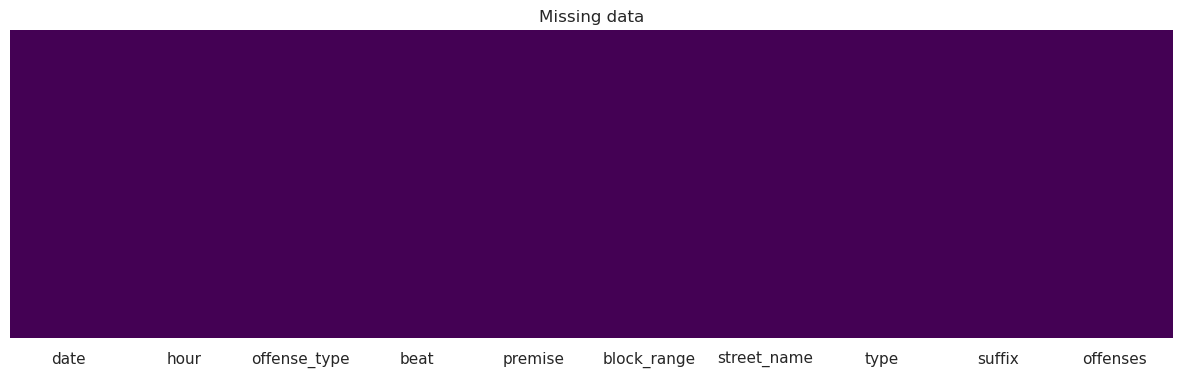

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Fix missing values

In [14]:
df[df.street_name.isna()]

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses
27116,01/03/2018,3,Burglary,7C30,Miscellaneous Business (Non-Specific),9200-9299,NaN,-,-,1


In [15]:
## Change null values to UNK

df["street_name"].fillna("UNK", inplace = True)

In [16]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

## Combine columns 

## Combine date & hour to one column

In [17]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47015 entries, 0 to 47014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   offense_type  47015 non-null  object        
 1   beat          47015 non-null  object        
 2   premise       47015 non-null  object        
 3   block_range   47015 non-null  object        
 4   street_name   47015 non-null  object        
 5   type          47015 non-null  object        
 6   suffix        47015 non-null  object        
 7   offenses      47015 non-null  int64         
 8   date_time     47015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 3.2+ MB


In [19]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Theft,10H10,Commercial Building,5900-5999,HARRISBURG,-,-,1,2018-04-03 14:00:00
1,Theft,10H10,"Road, Street, or Sidewalk",300-399,DELMAR,ST,-,1,2018-04-05 07:00:00
2,Theft,10H10,Apartment,2100-2199,RUNNELS,-,-,1,2018-04-05 17:00:00
3,Theft,10H10,Bar or Night Club Parking Lot,2400-2499,NAVIGATION,BLVD,-,1,2018-04-05 17:00:00
4,Aggravated Assault,10H10,Residence or House,3300-3399,NAVIGATION,BLVD,-,1,2018-04-07 04:00:00


## Convert offenses to integer

In [20]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47015 entries, 0 to 47014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   offense_type  47015 non-null  object        
 1   beat          47015 non-null  object        
 2   premise       47015 non-null  object        
 3   block_range   47015 non-null  object        
 4   street_name   47015 non-null  object        
 5   type          47015 non-null  object        
 6   suffix        47015 non-null  object        
 7   offenses      47015 non-null  int64         
 8   date_time     47015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 3.2+ MB


# Create year column

In [22]:
df['year'] = 2018
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time,year
0,Theft,10H10,Commercial Building,5900-5999,HARRISBURG,-,-,1,2018-04-03 14:00:00,2018
1,Theft,10H10,"Road, Street, or Sidewalk",300-399,DELMAR,ST,-,1,2018-04-05 07:00:00,2018
2,Theft,10H10,Apartment,2100-2199,RUNNELS,-,-,1,2018-04-05 17:00:00,2018
3,Theft,10H10,Bar or Night Club Parking Lot,2400-2499,NAVIGATION,BLVD,-,1,2018-04-05 17:00:00,2018
4,Aggravated Assault,10H10,Residence or House,3300-3399,NAVIGATION,BLVD,-,1,2018-04-07 04:00:00,2018


## change order of columns

In [24]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,year
0,2018-04-03 14:00:00,1,Theft,5900-5999,HARRISBURG,-,-,10H10,Commercial Building,2018
1,2018-04-05 07:00:00,1,Theft,300-399,DELMAR,ST,-,10H10,"Road, Street, or Sidewalk",2018
2,2018-04-05 17:00:00,1,Theft,2100-2199,RUNNELS,-,-,10H10,Apartment,2018
3,2018-04-05 17:00:00,1,Theft,2400-2499,NAVIGATION,BLVD,-,10H10,Bar or Night Club Parking Lot,2018
4,2018-04-07 04:00:00,1,Aggravated Assault,3300-3399,NAVIGATION,BLVD,-,10H10,Residence or House,2018


## Save to bucket

In [25]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2018.csv'

In [26]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 248 ms, sys: 10.3 ms, total: 259 ms
Wall time: 6.56 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2018.csv'],
 'partitions_values': {}}

# Save Sample

In [27]:
%%time
sample_100 = df.sample(100)


bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 376 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2018.csv'],
 'partitions_values': {}}